In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as rx
import rioxarray as rix
import rasterio as rio
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import TensorBoard


2024-01-09 10:32:02.167150: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/lucajuliusbarbera/opt/miniconda3/envs/urban/lib/python3.11/site-packages/h5py/__init__.py:36: UserWarning: h5py is running against HDF5 1.14.3 when it was built against 1.14.2, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


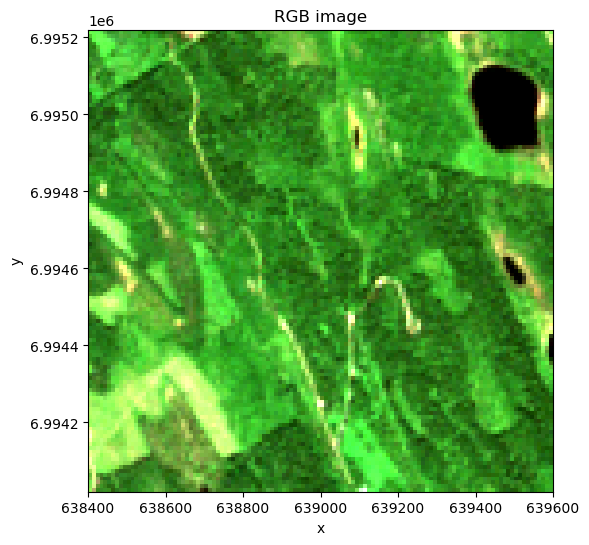

<xarray.DataArray ()>
array(-0.35042736, dtype=float32)
Coordinates:
    band         int64 1
    spatial_ref  int64 0
<xarray.DataArray ()>
array(0.5473079, dtype=float32)
Coordinates:
    band         int64 1
    spatial_ref  int64 0


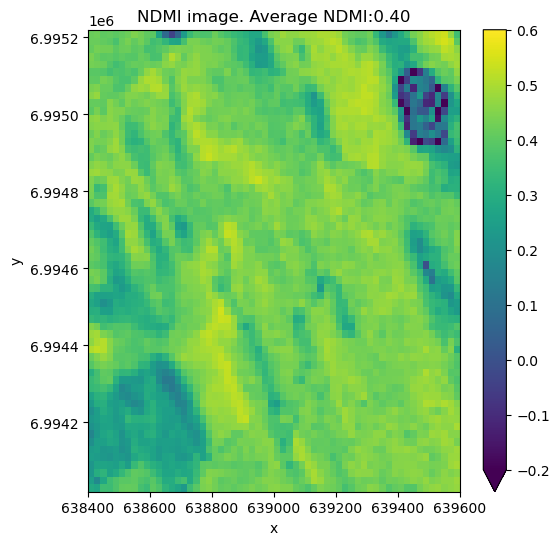

In [2]:
# JUST FOR PLOTTING
def norm_diff(x,y):
    return (x-y)/(x+y)

child = "S2B_MSIL2A_20170801T095029_11_32"  # good example for faulty NDMI and pretty picture
child = "S2A_MSIL2A_20170701T093031_32_4"  # non faulty NDMI


def plot_folder(folder,rgb=True):
    parent = "data/"
    if rgb:
        plt.figure(figsize=(6, 6))
        blue = rix.open_rasterio(parent+f"{folder}/{folder}_B02.tif")
        green = rix.open_rasterio(parent+f"{folder}/{folder}_B03.tif")
        red = rix.open_rasterio(parent+f"{folder}/{folder}_B04.tif")
        rgb_img = rx.concat([red, green, blue], dim='band')
        rgb_img.plot.imshow(robust=True)
        plt.title("RGB image")
        plt.show()

    elif not rgb:
        plt.figure(figsize=(6, 6))
        nir = rix.open_rasterio(parent+f"{folder}/{folder}_B8A.tif")
        swir = rix.open_rasterio(parent+f"{folder}/{folder}_B11.tif")
        nir = nir.astype('float32')
        swir = swir.astype('float32')

        avg_ndmi = np.mean(norm_diff(nir.values,swir.values).squeeze())
        ndmi_img = norm_diff(nir,swir).squeeze()

        ndmi_img.plot.imshow(robust=True,cmap='viridis',vmin=-0.2,vmax=0.6)
        plt.title(f"NDMI image. Average NDMI:{avg_ndmi:.2f}")
        plt.show()

plot_folder(child,rgb=True)
plot_folder(child,rgb=False)

In [3]:
def convert_to_geo_coords(x, y, transform):
    lon = transform[2] + x * transform[0] + y * transform[1]
    lat = transform[5] + x * transform[4] + y * transform[3]
    return lon, lat

child = "S2A_MSIL2A_20170701T093031_32_4"  # non faulty NDMI
blue = rix.open_rasterio(f"data/{child}/{child}_B02.tif")
x_image, y_image = 6.384e+05, 6.995e+06  # Replace with actual image coordinates
transform = blue.rio.transform()
vectorized_convert = np.vectorize(convert_to_geo_coords, excluded=['transform'])

# Apply the vectorized function to image coordinates
geo_coordinates = vectorized_convert(x_image, y_image, transform=transform)

print("Geographic Coordinates:", geo_coordinates)
#  need to find out how to show the location of our satellite image

Geographic Coordinates: (array(7022400.), array(611220.))


In [5]:
import os

def list_folders(directory):
    folders = [entry.name for entry in os.scandir(directory) if entry.is_dir()]
    return np.array(folders)

all_folders = list_folders("data/")
print(all_folders)
print(len(all_folders))

['S2A_MSIL2A_20180205T100211_88_76' 'S2A_MSIL2A_20170701T093031_25_48'
 'S2A_MSIL2A_20180205T100211_63_42' ... 'S2A_MSIL2A_20180225T114351_31_27'
 'S2B_MSIL2A_20170802T092029_10_37' 'S2A_MSIL2A_20180205T100211_19_22']
19056


In [9]:

# Read GeoTIFF file
def norm_diff(x,y):
    try:
        return (x-y)/(x+y)
    except Exception as e:
        print(e)
        return None


def get_input_label(folder):
    try:
        base_path=f"data/{folder}/{folder}"

        blue = rix.open_rasterio(f"{base_path}_B02.tif")
        green = rix.open_rasterio(f"{base_path}_B03.tif")
        red = rix.open_rasterio(f"{base_path}_B04.tif")     

        rgb = np.concatenate([red.values,green.values,blue.values], axis=0)

        nir = rix.open_rasterio(f"{base_path}_B8A.tif")
        swir = rix.open_rasterio(f"{base_path}_B11.tif")
        nir = nir.astype('float32')
        swir = swir.astype('float32')

        ndmi = norm_diff(nir.values.squeeze(),swir.values.squeeze())
        label = np.mean(ndmi)
        
        return rgb, label
    except Exception as e:
        print(e)
        return None, None

In [13]:
import os
from concurrent.futures import ProcessPoolExecutor
from folder_processing import process_folder

folders = all_folders.copy()

# Using np.zeros and np.stack for NumPy arrays
input = np.zeros((len(all_folders), 3, 120, 120), dtype=np.float32)
labels = np.zeros((len(all_folders), 1), dtype=np.float32)

with ProcessPoolExecutor() as executor:
    results = list(executor.map(process_folder, all_folders))

# Extract valid results
valid_results = [(rgb, label) for rgb, label in results if rgb is not None and label is not None]

# Unpack and assign results to NumPy arrays
input[:len(valid_results)] = np.array([rgb for rgb, _ in valid_results])
labels[:len(valid_results)] = np.array([label for _, label in valid_results]).reshape(-1, 1)

['S2A_MSIL2A_20180205T100211_88_76' 'S2A_MSIL2A_20170701T093031_25_48'
 'S2A_MSIL2A_20180205T100211_63_42' ... 'S2A_MSIL2A_20180225T114351_31_27'
 'S2B_MSIL2A_20170802T092029_10_37' 'S2A_MSIL2A_20180205T100211_19_22']
19056
data/S2B_MSIL2A_20170802T092029_18_24/S2B_MSIL2A_20170802T092029_18_24_B03.tif: No such file or directory


/Users/lucajuliusbarbera/urban/urban-computing-project-bigearthnet/folder_processing.py:7: RuntimeWarning: invalid value encountered in divide
  return (x-y)/(x+y)


data/S2A_MSIL2A_20170613T101031_24_59/S2A_MSIL2A_20170613T101031_24_59_B04.tif: No such file or directory


/Users/lucajuliusbarbera/urban/urban-computing-project-bigearthnet/folder_processing.py:7: RuntimeWarning: invalid value encountered in divide
  return (x-y)/(x+y)


data/S2A_MSIL2A_20170701T093031_86_9/S2A_MSIL2A_20170701T093031_86_9_B04.tif: No such file or directory


/Users/lucajuliusbarbera/urban/urban-computing-project-bigearthnet/folder_processing.py:7: RuntimeWarning: invalid value encountered in divide
  return (x-y)/(x+y)


In [9]:
# remove rows from label and input where label is nan or invalid (>1 or <-1)
faulty_row = (np.isnan(labels) | (np.abs(labels)>1)).squeeze()
labels_clean = labels[~faulty_row]
input_clean = input[~faulty_row]
folders_clean = folders[~faulty_row]

print("all folders:",len(labels))
print("clean folders:",len(labels_clean))
print(f"currently using {len(labels_clean)*100/500000:.2f}% of archive of 500k")

np.save("arrays/clean_folders2.npy", folders_clean,)
np.save("arrays/clean_labels2.npy", labels_clean)
np.save("arrays/clean_input2.npy", input_clean)

all folders: 19056
clean folders: 19046
currently using 3.81% of archive of 500k


In [2]:
folders_clean = np.load("arrays/clean_folders.npy")

input_clean = np.load("arrays/clean_input.npy")
input_clean = input_clean.reshape(len(input_clean),120,120,3)
input_shape = input_clean.shape
input_clean = tf.squeeze(input_clean)
labels_clean = np.load("arrays/clean_labels.npy")
labels_categorical = tf.keras.utils.to_categorical(labels_clean, num_classes=10)

(19046, 120, 120, 3)


In [8]:
# Convert labels to categorical
labels_categorical = tf.keras.utils.to_categorical(labels_clean, num_classes=10)

# Print the shape of the categorical labels
print(labels_categorical.shape)

input_copy = input_clean.copy()

# start constructing network for RGB dimension (120,120,3), reshape
input_clean = input_clean.reshape(len(input_clean),120,120,3)
input_shape = input_clean.shape

(19046, 10)


In [ ]:
# the actual training will happen in each .py file